### Generative vs. experience replay

Comparing the effect of generative vs. experience replay on generalisation.

#### Installation:

Local:

In [ ]:
!pip install numpy==1.24.2
!pip tensorflow-macos==2.11.0

Colab:

In [ ]:
!pip install wonderwords evaluate datasets accelerate

#### Imports:

In [1]:
from continual_learning_utils import *
from grid_environment_utils import * 
from testing_utils import * 
import random
import pandas as pd
import networkx as nx
import logging
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import evaluate
import random
import string
import os
import re
import glob
import csv
import torch
from wonderwords import RandomWord
import os
import gc
import pickle
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from itertools import permutations
import logging
from random import shuffle
from matplotlib import pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import math
from scipy.stats import sem


os.environ["WANDB_DISABLED"] = "true"

#### Test generative replay

Let's first create training data for 5 environments.

In [2]:
def train_model_script(name_or_path='spatial_model', 
                       num_epochs=3,
                       output_dir='./clm_script',
                       save_steps=100,
                       lr=5e-05):
    torch.cuda.empty_cache()
    gc.collect()
    ! python ./run_clm.py \
        --model_name_or_path {name_or_path} \
        --train_file {os.path.join(output_dir, 'train.txt')} \
        --validation_file {os.path.join(output_dir, 'train.txt')} \
        --per_device_train_batch_size 1 \
        --per_device_eval_batch_size 1 \
        --do_train \
        --do_eval \
        --output_dir {output_dir} \
        --overwrite_output_dir \
        --num_train_epochs {num_epochs} \
        --save_strategy 'steps' \
        --save_steps {save_steps} \
        --learning_rate {lr} 
                           

def train_on_env(training_strs, testing_strs, list_to_write, oversample_num=1000, eps=20, lr=5e-05, num_train=100, env=0, base_model='base_model', generated_strs=None):
    !rm -rf spatial_model_{env}
    !mkdir spatial_model_{env}

    dirname = f'spatial_model_{env}'
    
    text_file = open(dirname + "/train.txt", "w")

    list_to_write = np.random.choice(list_to_write, oversample_num).tolist()
    n = text_file.write('\n'.join(list_to_write))
    text_file.close()

    text_file = open(dirname + "/test.txt", "w")
    n = text_file.write('\n'.join(testing_strs[env]))
    text_file.close()
    
    train_model_script(name_or_path=base_model, 
                       output_dir=dirname, 
                       num_epochs=eps, 
                       save_steps=2000,
                       lr=lr)


def get_mean_perplexity(input_texts, model_path='spatial_model_0'):
    perplexity = evaluate.load("perplexity", module_type="metric")
    results = perplexity.compute(model_id=model_path,
                                 add_start_token=False,
                                 predictions=input_texts)
    return results


def generative_replay_v2(model, train_data, test_data, num=100, temperature=1, num_beams=5):
    examples = []
    all_data = train_data + test_data
    shuffle(all_data)
    for seq in test_data + train_data:
        out = model.continue_input(seq[:seq.index('PATH:')+5], 
                                   do_sample=False, num_beams=5)
        # Leave out the last sequence as it stopped midway through
        out = out.split('\n')[0]
        if out in train_data or out in test_data:
            examples.append(out)
            print(f"Appending {out} to training data")
    print(f"{len(list(set(examples)))} unique examples in a list of {len(examples)}")
    return random.choices(list(set(examples)), k=num)


def generative_replay_v3(model, train_data, test_data, num=100, temperature=1, num_beams=5):
    examples = []
    for seq in test_data + train_data:
        out = model.continue_input(seq[:seq.index('PATH:')+5], 
                                   do_sample=False, num_beams=num_beams)
        # Leave out the last sequence as it stopped midway through
        out = out.split('\n')[0]
        #if out in train_data or out in test_data:
        examples.append(out)
        print(f"Appending {out} to training data")
    examples = list(set(examples))
    # ps = get_mean_perplexity(examples)['perplexities']
    # ranked = [x for _, x in sorted(zip(ps, examples))][0:num]
    return random.choices(examples, k=num) #ranked


def experience_replay(i, training_strs, train_size=100, sample_size=10):
    # Get sample_size items from the first train_size items of each previous environment
    train_list = [training_strs[j][0:train_size] for j in range(0,i)]
    # Flatten this list
    train_list = [x for xs in train_list for x in xs]
    return random.choices(train_list, k=sample_size)

In [3]:
def plot_results(results):
    
    # Extract and organize data
    exp_rep_next_loc = np.array([result['experience_replay'][0] for result in results.values()])
    exp_rep_shortest_path = np.array([result['experience_replay'][1] for result in results.values()])
    gen_rep_next_loc = np.array([result['generative_replay'][0] for result in results.values()])
    gen_rep_shortest_path = np.array([result['generative_replay'][1] for result in results.values()])
    
    # Calculate means
    means_exp_rep = [exp_rep_next_loc.mean(), exp_rep_shortest_path.mean()]
    means_gen_rep = [gen_rep_next_loc.mean(), gen_rep_shortest_path.mean()]
    
    # Calculate SEMs
    sems_exp_rep = [sem(exp_rep_next_loc), sem(exp_rep_shortest_path)]
    sems_gen_rep = [sem(gen_rep_next_loc), sem(gen_rep_shortest_path)]
    
    # Plotting
    x = np.arange(2)  # Number of groups
    width = 0.35  # Width of bars
    
    fig, ax = plt.subplots(figsize=(5,3))
    rects1 = ax.bar(x - width/2, means_exp_rep, width, yerr=sems_exp_rep, label='Experience replay', capsize=0, 
                    color='blue', alpha=0.5)
    rects2 = ax.bar(x + width/2, means_gen_rep, width, yerr=sems_gen_rep, label='Generative replay', capsize=0, 
                    color='red', alpha=0.5)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(['Next location prediction', 'Shortest path prediction'])
    ax.legend()
    
    fig.tight_layout()
    plt.savefig('two_task_grouped_bar.png', dpi=500)
    plt.show()


In [ ]:
train_size=50
sample_size=100

results = {}

for i in range(0, 5):
    results[i] = {}
    
    training_strs, testing_strs = prepare_data(short_paths=True)
    
    list_to_write = training_strs[0][0:train_size]
    train_on_env(training_strs, 
         testing_strs, 
         list_to_write,
         eps=10, 
         lr=5e-05,
         num_train=train_size, 
         env=0, 
         base_model='base_model_b8', 
         oversample_num=4000)
    
    # EXPERIENCE REPLAY
    
    replayed_strs = random.choices(training_strs[0][0:train_size], k=sample_size)
    
    print(f"Replayed strings: {replayed_strs}")
    train_on_env(training_strs, 
                 testing_strs, 
                 training_strs[1][:train_size] + replayed_strs,
                 eps=10, 
                 lr=5e-05,
                 num_train=train_size, 
                 env=1, 
                 base_model=f'spatial_model_0',
                 oversample_num=1000)
    
    # Test on all environments
    model = GPT(base_model=f'spatial_model_1')
    with open(f"spatial_model_0/test.txt", 'r') as file:
        test_data = [line.strip() for line in file]
    print(f"Test data: {test_data}")
    accuracy = test_accuracy(model, test_data)
    print(f"Next node accuracy: {accuracy}")    
    
    sp_accuracy = shortest_path_accuracy(model, 
                                      test_data_subset(test_data, training_strs[0][:train_size]), 
                                      training_strs[0] + testing_strs[0])
    print(f"Shortest path accuracy: {sp_accuracy}")  
    
    results[i]['experience_replay'] = [accuracy, sp_accuracy]
    
    # GENERATIVE REPLAY
    
    generated_strs = generative_replay_v3(GPT(base_model=f'spatial_model_0'), 
                                          training_strs[0], 
                                          testing_strs[0], 
                                          num=sample_size,
                                          num_beams=5)
    
    print(f"Generated strings: {generated_strs}")
    train_on_env(training_strs, 
                 testing_strs, 
                 training_strs[1][:train_size] + generated_strs,
                 eps=10, 
                 lr=5e-05,
                 num_train=train_size, 
                 env=1, 
                 base_model=f'spatial_model_0',
                 oversample_num=1000)

    # Test on all environments
    model = GPT(base_model=f'spatial_model_1')
    with open(f"spatial_model_0/test.txt", 'r') as file:
        test_data = [line.strip() for line in file]
    print(f"Test data: {test_data}")
    accuracy = test_accuracy(model, test_data)
    print(f"Next node accuracy: {accuracy}")    
    
    sp_accuracy = shortest_path_accuracy(model, 
                                      test_data_subset(test_data, training_strs[0][:train_size]), 
                                      training_strs[0] + testing_strs[0])
    print(f"Shortest path accuracy: {sp_accuracy}")  
    
    results[i]['generative_replay'] = [accuracy, sp_accuracy]
    pd.DataFrame(results).to_csv('results.csv')

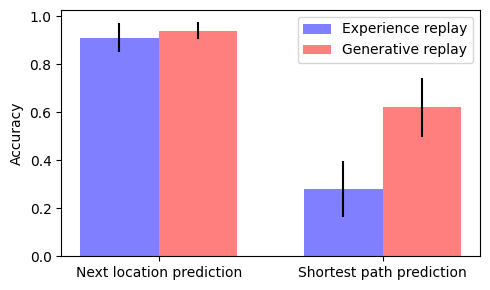

In [4]:
df = pd.read_csv('results_exp_vs_gen_final.csv')

desired_dict = {}
for index, row in df.iterrows():
    key = row['Unnamed: 0']
    for col in df.columns[1:]:
        value = eval(row[col])
        if int(col) not in desired_dict:
            desired_dict[int(col)] = {}
        desired_dict[int(col)][key] = value

plot_results(desired_dict)

#### Generative data augmentation

Test effect of training on environmnent 0 with and without generative data augmentation.

In [ ]:
# train_size=50
# sample_size=100

# results = {}

# for i in range(0, 5):
#     results[i] = {}
    
#     training_strs, testing_strs = prepare_data(short_paths=True)
    
#     list_to_write = training_strs[0][0:train_size]
#     train_on_env(training_strs, 
#          testing_strs, 
#          list_to_write,
#          eps=10, 
#          lr=5e-05,
#          num_train=train_size, 
#          env=0, 
#          base_model='base_model_b8', 
#          oversample_num=4000)
    
#     # EXPERIENCE REPLAY
    
#     train_on_env(training_strs, 
#                  testing_strs, 
#                  training_strs[0][:train_size],
#                  eps=10, 
#                  lr=5e-05,
#                  num_train=train_size, 
#                  env=1, 
#                  base_model=f'spatial_model_0',
#                  oversample_num=1000)
    
#     # Test on all environments
#     model = GPT(base_model=f'spatial_model_1')
#     with open(f"spatial_model_0/test.txt", 'r') as file:
#         test_data = [line.strip() for line in file]
#     print(f"Test data: {test_data}")
#     accuracy = test_accuracy(model, test_data)
#     print(f"Next node accuracy: {accuracy}")    
    
#     sp_accuracy = shortest_path_accuracy(model, 
#                                       test_data_subset(test_data, training_strs[0][:train_size]), 
#                                       training_strs[0] + testing_strs[0])
#     print(f"Shortest path accuracy: {sp_accuracy}")  
    
#     results[i]['experience_replay'] = [accuracy, sp_accuracy]
    
#     # GENERATIVE REPLAY
    
#     generated_strs = generative_replay_v3(GPT(base_model=f'spatial_model_0'), 
#                                           training_strs[0], 
#                                           testing_strs[0], 
#                                           num=sample_size,
#                                           num_beams=5)
    
#     print(f"Generated strings: {generated_strs}")
#     train_on_env(training_strs, 
#                  testing_strs, 
#                  training_strs[0][:train_size] + generated_strs,
#                  eps=10, 
#                  lr=5e-05,
#                  num_train=train_size, 
#                  env=1, 
#                  base_model=f'spatial_model_0',
#                  oversample_num=1000)

#     # Test on all environments
#     model = GPT(base_model=f'spatial_model_1')
#     with open(f"spatial_model_0/test.txt", 'r') as file:
#         test_data = [line.strip() for line in file]
#     print(f"Test data: {test_data}")
#     accuracy = test_accuracy(model, test_data)
#     print(f"Next node accuracy: {accuracy}")    
    
#     sp_accuracy = shortest_path_accuracy(model, 
#                                       test_data_subset(test_data, training_strs[0][:train_size]), 
#                                       training_strs[0] + testing_strs[0])
#     print(f"Shortest path accuracy: {sp_accuracy}")  
    
#     results[i]['generative_replay'] = [accuracy, sp_accuracy]
#     pd.DataFrame(results).to_csv('results.csv')